In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import fv3viz
import vcm

import common

In [2]:
group = "zc-emu-monthly-seed5-m06-30d-v1-online"
url = common.get_group_url(group)

In [3]:
data = vcm.fv3.metadata.gfdl_to_standard(xr.open_zarr(f"{url}/piggy.zarr"))
grid = vcm.catalog.catalog["grid/c48"].to_dask()
data = data.merge(grid)

In [4]:
dt = 900 # s
seconds_per_day = 60 * 60 * 24  # seconds/min * min/hr * hr/day
m_to_mm = 1000
rho_water = 1000

def kg_m2_s_to_mm_day(da):
    return da * seconds_per_day / rho_water * m_to_mm

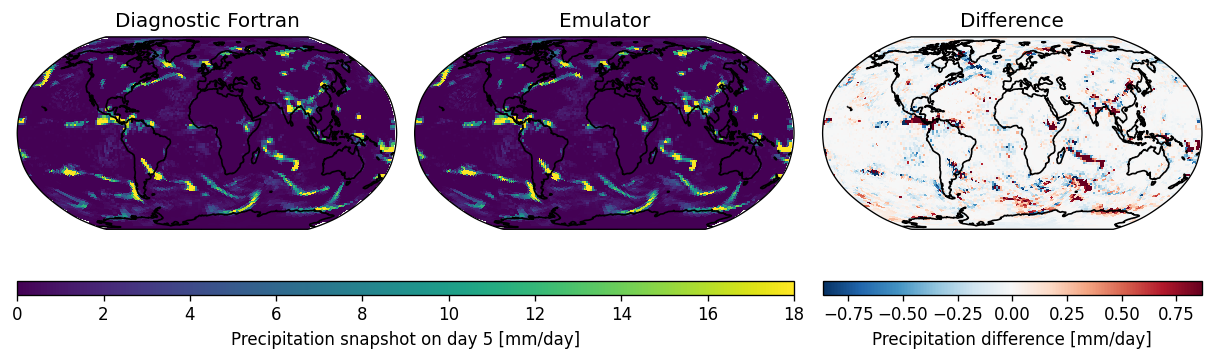

In [10]:
fig = plt.figure(constrained_layout=True, figsize=(10,3), dpi=120)
gs = fig.add_gridspec(ncols=3, nrows=2, width_ratios=[1,1,1], height_ratios=[20,1])
proj_ax = [fig.add_subplot(gs[0, i], projection=ccrs.Robinson()) for i in range(3)]
cb_ax_main = fig.add_subplot(gs[1,0:2])
cb_ax_diff = fig.add_subplot(gs[1,2])


phys_key = "surface_precipitation_due_to_zhao_carr_physics"
emu_key = "surface_precipitation_due_to_zhao_carr_emulator"
pdata = data.isel(time=80) # day 10
pdata[phys_key] = kg_m2_s_to_mm_day(pdata[phys_key])
pdata[emu_key] = kg_m2_s_to_mm_day(pdata[emu_key])
diff = (pdata[emu_key] - pdata[phys_key]).to_dataset(name="difference").merge(grid)

fv3viz.plot_cube(pdata, phys_key, plotting_function="pcolormesh", ax=proj_ax[0],
vmin=0, vmax=18, colorbar=True, cbar_ax=cb_ax_main, cbar_kwargs=dict(orientation="horizontal"),
    cbar_label="Precipitation snapshot on day 5 [mm/day]")
fv3viz.plot_cube(pdata, emu_key, ax=proj_ax[1], colorbar=False,
    plotting_function="pcolormesh", vmin=0, vmax=18, cbar_label="mm/day")
fv3viz.plot_cube(diff, "difference", ax=proj_ax[2], colorbar=True, 
    cbar_ax=cb_ax_diff, cbar_kwargs=dict(orientation="horizontal"), 
    cbar_label="Precipitation difference [mm/day]")

proj_ax[0].set_title("Diagnostic Fortran")
proj_ax[1].set_title("Emulator")
proj_ax[2].set_title("Difference")
plt.show()
